In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import os

print(torch.get_num_threads())
print(torch.get_num_interop_threads())

32
32


In [2]:
class FullModel(torch.nn.Module):
    def __init__(self):
        super(FullModel, self).__init__()
        self.fc1 = torch.nn.Linear(1, 8)
        self.fc2 = torch.nn.Linear(8, 8)
        self.fc3 = torch.nn.Linear(8, 1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [3]:
def func(x):
    return np.power(x, 1) * np.power(np.sin(1.0 / 3.0 * x), 2)

def avg_l2_diff(y1, y2):
    return np.average(np.power(y1-y2, 2))

In [4]:
seed = 1

In [5]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(True)

In [6]:
#=================================================================

In [7]:
model = FullModel()

In [8]:
#x_train_orig = np.arange(-2.4, 2.8, 0.4)
#x_train_orig = np.arange(-2.4, 2.6, 0.2)
#x_train_orig = np.arange(-2.4, 2.5, 0.1)
x_train_orig = np.arange(-2.4, 2.45, 0.05)

x_train = x_train_orig
nsample = x_train.shape[0] - 1

In [9]:
y_train = func(x_train)
print(y_train)

[-1.23503943e+00 -1.17014766e+00 -1.10692763e+00 -1.04542065e+00
 -9.85664259e-01 -9.27692230e-01 -8.71534500e-01 -8.17217159e-01
 -7.64762427e-01 -7.14188642e-01 -6.65510254e-01 -6.18737822e-01
 -5.73878021e-01 -5.30933655e-01 -4.89903674e-01 -4.50783200e-01
 -4.13563554e-01 -3.78232297e-01 -3.44773271e-01 -3.13166647e-01
 -2.83388980e-01 -2.55413271e-01 -2.29209030e-01 -2.04742347e-01
 -1.81975974e-01 -1.60869402e-01 -1.41378948e-01 -1.23457852e-01
 -1.07056370e-01 -9.21218767e-02 -7.85989733e-02 -6.64295961e-02
 -5.55531323e-02 -4.59065393e-02 -3.74244664e-02 -3.00393817e-02
 -2.36817018e-02 -1.82799241e-02 -1.37607634e-02 -1.00492899e-02
 -7.06907095e-03 -4.74231414e-03 -2.99001332e-03 -1.73209605e-03
 -8.87572797e-04 -3.74687604e-04 -1.11069965e-04 -1.38876029e-05
 -6.67465706e-44  1.38876029e-05  1.11069965e-04  3.74687604e-04
  8.87572797e-04  1.73209605e-03  2.99001332e-03  4.74231414e-03
  7.06907095e-03  1.00492899e-02  1.37607634e-02  1.82799241e-02
  2.36817018e-02  3.00393

In [10]:
x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).float()
train_dataset = torch.utils.data.TensorDataset(x_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True)

In [11]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.02, weight_decay=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

criterion = torch.nn.MSELoss()

In [12]:
def train(epoch):
    model.train()
    
    running_loss  = torch.tensor(0.0)

    for batch_idx, current_batch in enumerate(train_loader):     
        inp, current_batch_y = current_batch[0],        current_batch[1]

        optimizer.zero_grad()
        output = model(inp)
        gndtruth = current_batch_y

        loss = criterion(output, gndtruth)
        loss.backward()
        optimizer.step()
        running_loss  += loss.item()

    running_loss  = running_loss  / len(train_loader)
    if epoch % 40 == 0:
        print("epoch: {}, Average loss: {:15.8f}".format(epoch, running_loss))

In [13]:
for epoch in range(1, 2000):
    train(epoch)

epoch: 40, Average loss:      0.00607742
epoch: 80, Average loss:      0.00086885
epoch: 120, Average loss:      0.00045435
epoch: 160, Average loss:      0.00036967
epoch: 200, Average loss:      0.00031362
epoch: 240, Average loss:      0.00031131
epoch: 280, Average loss:      0.00029321
epoch: 320, Average loss:      0.00027985
epoch: 360, Average loss:      0.00023434
epoch: 400, Average loss:      0.00023568
epoch: 440, Average loss:      0.00022050
epoch: 480, Average loss:      0.00023136
epoch: 520, Average loss:      0.00019323
epoch: 560, Average loss:      0.00020199
epoch: 600, Average loss:      0.00019134
epoch: 640, Average loss:      0.00018209
epoch: 680, Average loss:      0.00016263
epoch: 720, Average loss:      0.00014797
epoch: 760, Average loss:      0.00015950
epoch: 800, Average loss:      0.00014465
epoch: 840, Average loss:      0.00016811
epoch: 880, Average loss:      0.00015802
epoch: 920, Average loss:      0.00013820
epoch: 960, Average loss:      0.000

In [14]:
x_pred_np = np.arange(-2.5, 2.5001, 0.0001).reshape(-1, 1)
x_pred = torch.from_numpy(x_pred_np).float()

In [15]:
y_true = func(x_pred_np)
y_pred = model(x_pred)

In [16]:
x_np = x_pred_np.reshape(-1)
y_pred_np = y_pred.detach().numpy().reshape(-1)
y_true_np = y_true.reshape(-1)

In [17]:
print(avg_l2_diff(y_pred_np, y_true_np))

0.000140458339364572


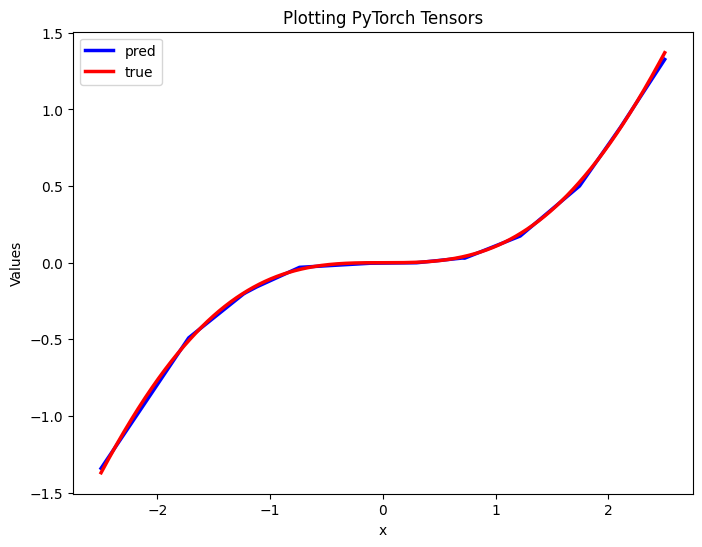

In [18]:
plt.figure(figsize=(8, 6))

# Plot y1 and y2 against x
plt.plot(x_np, y_pred_np, 'b-', label='pred', linewidth=2.5)
plt.plot(x_np, y_true_np, 'r-', label='true', linewidth=2.5)

# Set labels and title
plt.xlabel('x')
plt.ylabel('Values')
plt.title('Plotting PyTorch Tensors')

# Add a legend
plt.legend()

# Show the plot
plt.show()

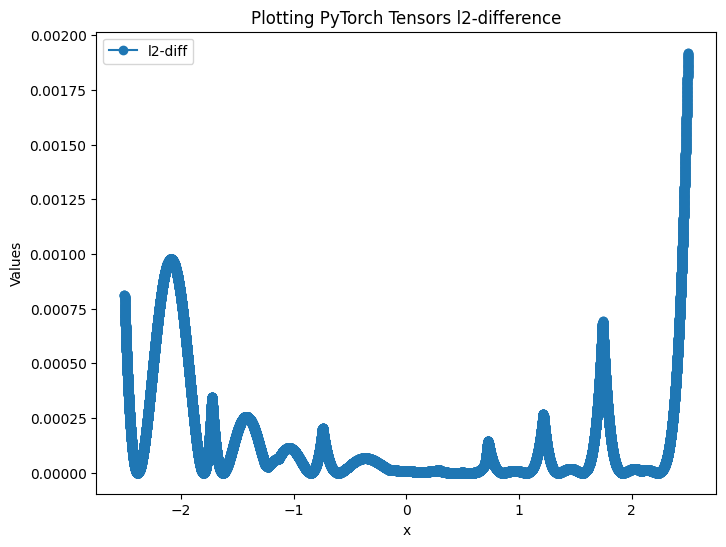

In [19]:
plt.figure(figsize=(8, 6))

# Plot y1 and y2 against x
plt.plot(x_np, np.power(y_pred_np - y_true_np, 2), label='l2-diff', marker='o')
#plt.plot(x_np, np.log(np.power(y_pred_np - y_true_np, 2)), label='log-l2-diff', marker='s')

# Set labels and title
plt.xlabel('x')
plt.ylabel('Values')
plt.title('Plotting PyTorch Tensors l2-difference')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [20]:
rng = np.random.default_rng(seed)
sigma = 0.01

cov = sigma * sigma
res = np.empty([0])
print(res)

[]


In [21]:
w = np.power(y_pred_np - y_true_np, 2)
w = w / np.sum(w)
sz = w.shape[0]
#freq = rng.multinomial(2 * nsample + 1, w)
freq = rng.multinomial(nsample, w)
print(freq)
print(np.sum(freq))
print(sz)
print(freq.shape[0])
print(x_pred.shape[0])

[0 0 0 ... 0 0 0]
96
50001
50001
50001


In [22]:
for i in range(sz):
    if freq[i]:
        #########################################
        #temp_out = rng.multivariate_normal(np.array([x_np[i]]), np.diag(np.array([cov])), freq[i]).reshape(-1)
        #print(temp_out)
        #temp_out = _remove_out_of_box(temp_out)
        #res = np.concatenate((res, temp_out), axis=0)
        #########################################
        res = np.concatenate((res, [x_np[i]]), axis=0)
        #########################################
        
print(res)        

[-2.4892 -2.4814 -2.4359 -2.2554 -2.2341 -2.2188 -2.1935 -2.1738 -2.1713
 -2.1563 -2.1558 -2.1545 -2.1495 -2.149  -2.1475 -2.1425 -2.1358 -2.1211
 -2.1093 -2.1088 -2.1034 -2.0984 -2.0926 -2.0865 -2.0735 -2.0597 -2.0515
 -2.0512 -2.0508 -2.032  -2.0309 -2.0218 -1.9979 -1.9792 -1.9741 -1.9711
 -1.9585 -1.9463 -1.9364 -1.9357 -1.9183 -1.9082 -1.7237 -1.4897 -1.4458
 -1.4454 -1.4006 -1.3884 -1.3444 -1.3278 -1.3179 -1.2557 -1.0391 -0.7259
 -0.6956 -0.4697 -0.2788 -0.2709  0.2812  0.7934  1.1841  1.2179  1.2219
  1.2318  1.659   1.7214  1.7472  1.7564  1.7577  1.7581  1.7602  1.7662
  1.8022  1.8141  2.2862  2.3665  2.3909  2.4001  2.4268  2.4324  2.4325
  2.4356  2.4396  2.4401  2.4418  2.4462  2.4525  2.4711  2.4757  2.4823
  2.488   2.491   2.4944  2.4957  2.4962  2.4971]


In [23]:
# seed = 1
# torch.manual_seed(seed)
# random.seed(seed)
# np.random.seed(seed)
# torch.use_deterministic_algorithms(True)

# model = FullModel()
# #x_train = x_train_orig
# #x_train = np.concatenate((x_train, res), axis=0)
# x_train = res
# y_train = func(x_train)
# x_train_torch = torch.from_numpy(x_train).float()
# y_train_torch = torch.from_numpy(y_train).float()
# train_dataset = torch.utils.data.TensorDataset(x_train_torch, y_train_torch)
# train_loader = torch.utils.data.DataLoader(
#     train_dataset, shuffle=True)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
# criterion = torch.nn.MSELoss()

# def train(epoch):
#     model.train()
    
#     running_loss  = torch.tensor(0.0)

#     for batch_idx, current_batch in enumerate(train_loader):     
#         inp, current_batch_y = current_batch[0],        current_batch[1]

#         optimizer.zero_grad()
#         output = model(inp)
#         gndtruth = current_batch_y

#         loss = criterion(output, gndtruth)
#         loss.backward()
#         optimizer.step()
#         running_loss  += loss.item()

#     running_loss  = running_loss  / len(train_loader)
#     if epoch % 40 == 0:
#         print("epoch: {}, Average loss: {:15.8f}".format(epoch, running_loss))
    
# for epoch in range(1, 2000):
#     train(epoch)
    
# x_pred_np = np.arange(-2.5, 2.5001, 0.0001).reshape(-1, 1)
# x_pred = torch.from_numpy(x_pred_np).float() 
# y_true = func(x_pred)
# y_pred = model(x_pred)
# x_np = x_pred.numpy().reshape(-1)
# y_pred_np = y_pred.detach().numpy().reshape(-1)
# y_true_np = y_true.numpy().reshape(-1)
# print(avg_l2_diff(y_pred_np, y_true_np))

In [24]:
x_train = x_train_orig
x_train = np.concatenate((x_train, res), axis=0)
#x_train = res
y_train = func(x_train)
x_train_torch = torch.from_numpy(x_train).float()
y_train_torch = torch.from_numpy(y_train).float()
train_dataset = torch.utils.data.TensorDataset(x_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True)
   
for epoch in range(1, 2000):
    train(epoch)
    
x_pred_np = np.arange(-2.5, 2.5001, 0.0001).reshape(-1, 1)
x_pred = torch.from_numpy(x_pred_np).float() 
y_true = func(x_pred)
y_pred = model(x_pred)
x_np = x_pred.numpy().reshape(-1)
y_pred_np = y_pred.detach().numpy().reshape(-1)
y_true_np = y_true.numpy().reshape(-1)
print(avg_l2_diff(y_pred_np, y_true_np))

epoch: 40, Average loss:      0.00012357
epoch: 80, Average loss:      0.00009824
epoch: 120, Average loss:      0.00009601
epoch: 160, Average loss:      0.00008949
epoch: 200, Average loss:      0.00008559
epoch: 240, Average loss:      0.00007941
epoch: 280, Average loss:      0.00008209
epoch: 320, Average loss:      0.00008116
epoch: 360, Average loss:      0.00007656
epoch: 400, Average loss:      0.00006806
epoch: 440, Average loss:      0.00006933
epoch: 480, Average loss:      0.00007252
epoch: 520, Average loss:      0.00007364
epoch: 560, Average loss:      0.00007225
epoch: 600, Average loss:      0.00006552
epoch: 640, Average loss:      0.00006858
epoch: 680, Average loss:      0.00006946
epoch: 720, Average loss:      0.00007005
epoch: 760, Average loss:      0.00006684
epoch: 800, Average loss:      0.00005600
epoch: 840, Average loss:      0.00006404
epoch: 880, Average loss:      0.00006923
epoch: 920, Average loss:      0.00006910
epoch: 960, Average loss:      0.000

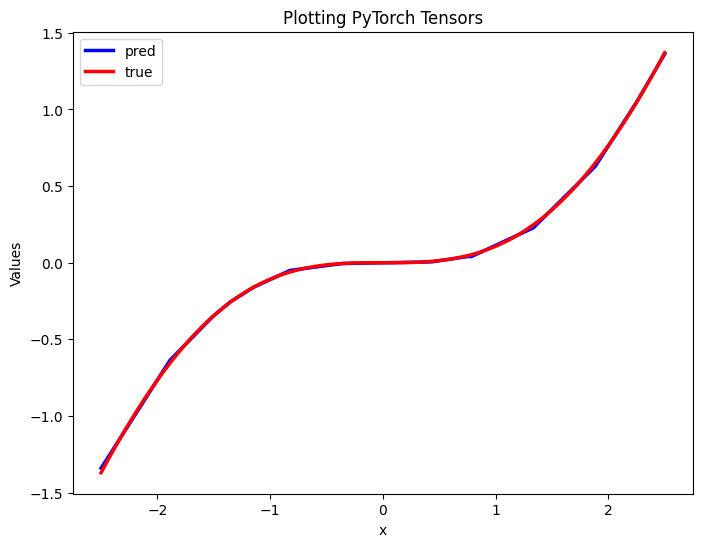

In [25]:
plt.figure(figsize=(8, 6))

# Plot y1 and y2 against x
plt.plot(x_np, y_pred_np, 'b-', label='pred', linewidth=2.5)
plt.plot(x_np, y_true_np, 'r-', label='true', linewidth=2.5)

# Set labels and title
plt.xlabel('x')
plt.ylabel('Values')
plt.title('Plotting PyTorch Tensors')

# Add a legend
plt.legend()

# Show the plot
plt.show()

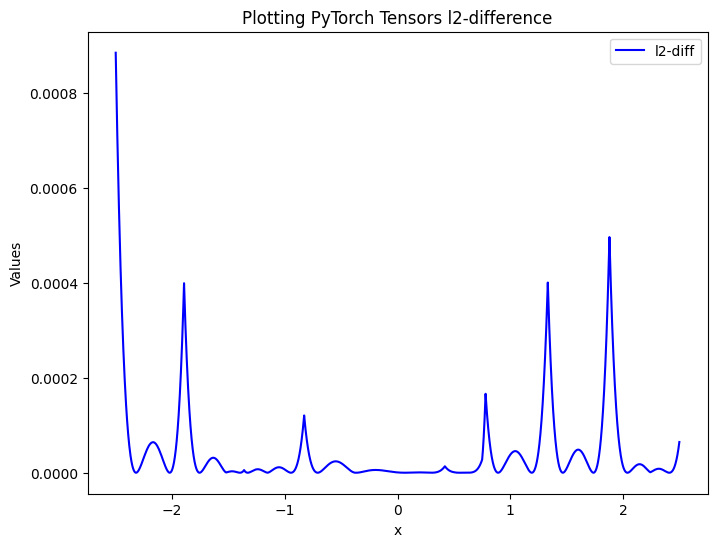

In [26]:
plt.figure(figsize=(8, 6))

# Plot y1 and y2 against x
plt.plot(x_np, np.power(y_pred_np - y_true_np, 2), 'b-', label='l2-diff')
#plt.plot(x_np, np.log(np.power(y_pred_np - y_true_np, 2)), label='log-l2-diff', marker='s')

# Set labels and title
plt.xlabel('x')
plt.ylabel('Values')
plt.title('Plotting PyTorch Tensors l2-difference')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [27]:
print(avg_l2_diff(y_pred_np, y_true_np))

4.1051855e-05
